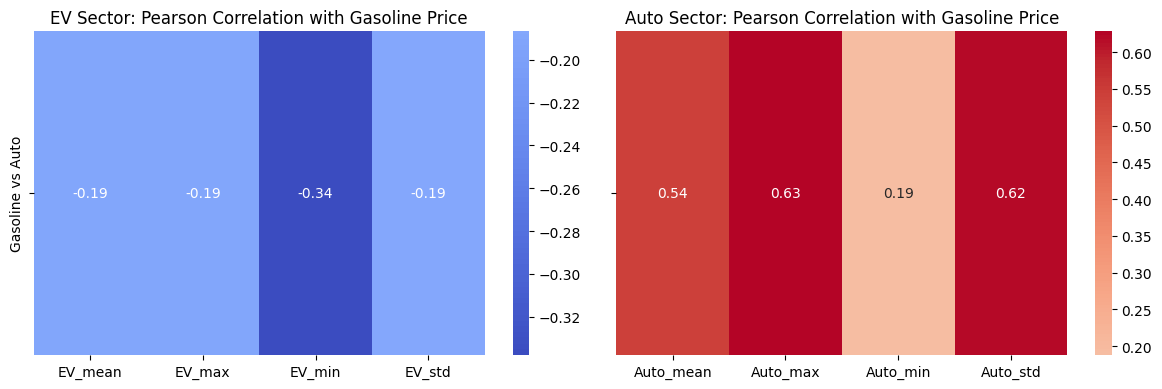

In [2]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Load gasoline data
gasoline_df = pd.read_csv("datathon data/weekly_gasoline_prices.csv")
gasoline_df['Date'] = pd.to_datetime(gasoline_df['Date'])

# Filter: US + Regular gasoline
gasoline_df = gasoline_df[
    (gasoline_df['Geography'] == 'US') &
    (gasoline_df['Type_Clean'].str.contains("Regular", case=False))
][['Date', 'Price']].rename(columns={"Price": "Gasoline_Price"})

# Set datetime index
gasoline_df.set_index("Date", inplace=True)

# 🔹 Load EV and Auto stock data
ev_df = pd.read_csv("Filtered_EV_Stock_Data_Truncated_4dp_From_2018-09-12.csv", parse_dates=["Date"])
auto_df = pd.read_csv("Filtered_Traditional_Auto_Stock_Data_Truncated_4dp_From_2018-09-12.csv", parse_dates=["Date"])
ev_df.set_index("Date", inplace=True)
auto_df.set_index("Date", inplace=True)

# 🔹 Resample stock data to weekly frequency and compute stats
ev_weekly = ev_df.resample('W').agg(['mean', 'max', 'min', 'std'])
auto_weekly = auto_df.resample('W').agg(['mean', 'max', 'min', 'std'])

# Flatten multiindex column names
ev_weekly.columns = ['_'.join(col) for col in ev_weekly.columns]
auto_weekly.columns = ['_'.join(col) for col in auto_weekly.columns]

# 🔹 Sector-level metrics (average across all companies)
ev_sector = pd.DataFrame({
    'EV_mean': ev_weekly.mean(axis=1),
    'EV_max': ev_weekly.max(axis=1),
    'EV_min': ev_weekly.min(axis=1),
    'EV_std': ev_weekly.std(axis=1)
})

auto_sector = pd.DataFrame({
    'Auto_mean': auto_weekly.mean(axis=1),
    'Auto_max': auto_weekly.max(axis=1),
    'Auto_min': auto_weekly.min(axis=1),
    'Auto_std': auto_weekly.std(axis=1)
})

# 🔹 Resample gasoline to weekly to match
gasoline_weekly = gasoline_df.resample('W').mean()

# 🔹 Merge all datasets
combined = gasoline_weekly.join(ev_sector).join(auto_sector).dropna()

# 🔹 Compute Pearson correlations
ev_corr = combined[['EV_mean', 'EV_max', 'EV_min', 'EV_std']].corrwith(combined['Gasoline_Price']).to_frame().T
auto_corr = combined[['Auto_mean', 'Auto_max', 'Auto_min', 'Auto_std']].corrwith(combined['Gasoline_Price']).to_frame().T
ev_corr.index = ['Gasoline vs EV']
auto_corr.index = ['Gasoline vs Auto']

# 🔹 Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.heatmap(ev_corr, annot=True, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title("EV Sector: Pearson Correlation with Gasoline Price")

sns.heatmap(auto_corr, annot=True, cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title("Auto Sector: Pearson Correlation with Gasoline Price")

plt.tight_layout()
plt.show()


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# --- Step 1: Create lag features of gasoline price ---
combined_lagged = combined.copy()
combined_lagged['Gasoline_t'] = combined_lagged['Gasoline_Price']
combined_lagged['Gasoline_t-1'] = combined_lagged['Gasoline_Price'].shift(1)
combined_lagged['Gasoline_t-2'] = combined_lagged['Gasoline_Price'].shift(2)

# Drop rows with NaNs due to lagging
combined_lagged = combined_lagged.dropna()

# --- Step 2: Set up features and targets ---
X = combined_lagged[['Gasoline_t', 'Gasoline_t-1', 'Gasoline_t-2']]
y_ev = combined_lagged['EV_mean']
y_auto = combined_lagged['Auto_mean']

# --- Step 3: Train models ---
model_ev = LinearRegression().fit(X, y_ev)
model_auto = LinearRegression().fit(X, y_auto)

# --- Step 4: Evaluate ---
def print_model_summary(name, model, X, y):
    print(f"📊 Linear Regression: {name}")
    print(f"  Coefficients: {model.coef_}")
    print(f"  Intercept:    {model.intercept_:.4f}")
    print(f"  R² Score:     {r2_score(y, model.predict(X)):.4f}")
    print()

print_model_summary("EV_mean ~ Gasoline lags", model_ev, X, y_ev)
print_model_summary("Auto_mean ~ Gasoline lags", model_auto, X, y_auto)


📊 Linear Regression: EV_mean ~ Gasoline lags
  Coefficients: [-5938.83040424  4341.72250327    60.30254757]
  Intercept:    6686.7744
  R² Score:     0.0470

📊 Linear Regression: Auto_mean ~ Gasoline lags
  Coefficients: [12.03336643 -6.69211467 -1.52220021]
  Intercept:    16.0267
  R² Score:     0.3091



/var/folders/n7/sn8w6zgn143919fscz6p_xnm0000gn/T/ipykernel_48917/3855269160.py:14: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/shrutibose/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


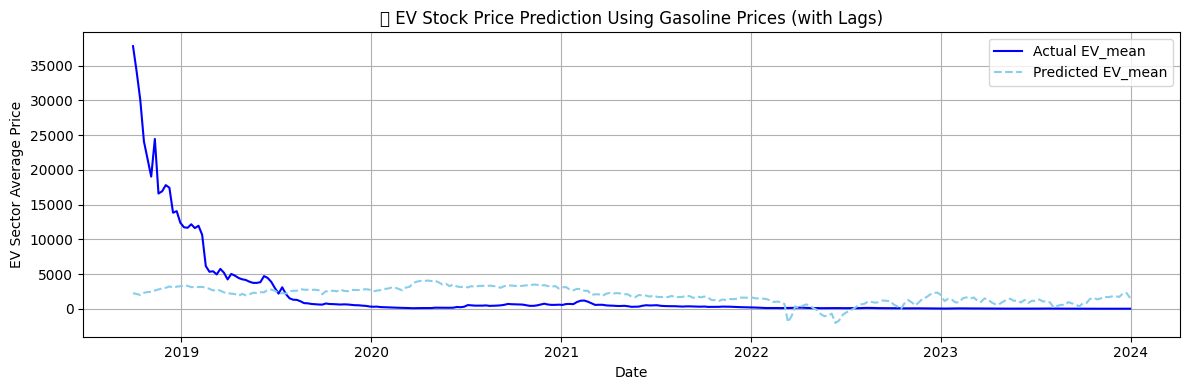

/var/folders/n7/sn8w6zgn143919fscz6p_xnm0000gn/T/ipykernel_48917/3855269160.py:26: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/shrutibose/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


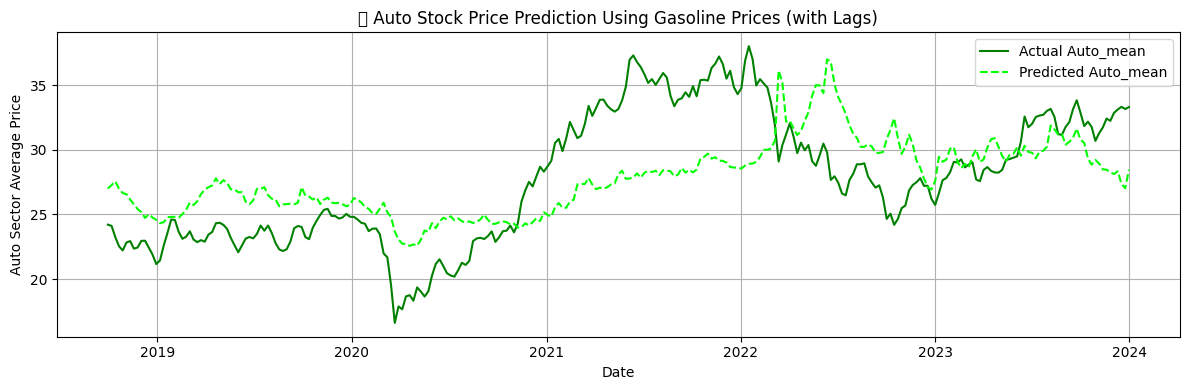

In [7]:
# Predict values
y_ev_pred = model_ev.predict(X)
y_auto_pred = model_auto.predict(X)

# --- EV Prediction Plot ---
plt.figure(figsize=(12, 4))
plt.plot(combined_lagged.index, y_ev, label='Actual EV_mean', color='blue')
plt.plot(combined_lagged.index, y_ev_pred, label='Predicted EV_mean', linestyle='--', color='skyblue')
plt.title("📉 EV Stock Price Prediction Using Gasoline Prices (with Lags)")
plt.xlabel("Date")
plt.ylabel("EV Sector Average Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Auto Prediction Plot ---
plt.figure(figsize=(12, 4))
plt.plot(combined_lagged.index, y_auto, label='Actual Auto_mean', color='green')
plt.plot(combined_lagged.index, y_auto_pred, label='Predicted Auto_mean', linestyle='--', color='lime')
plt.title("🚗 Auto Stock Price Prediction Using Gasoline Prices (with Lags)")
plt.xlabel("Date")
plt.ylabel("Auto Sector Average Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
